Statistic plots of elgRate ke, division time td and cell length-at-birth Lb
* ref: GrowthRate+SizeControl/SizeControl/2013-PNAS, 2015-currbio, 2016-PRE
* 

In [1]:
# import the essential packages 
import numpy as np   # for numerics
import glob   #for parsing directories and files
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  #for plotting
import random
import cv2
from PIL import Image
import os
from matplotlib import cm
import json
import pickle
import pandas as pd

import scipy.stats

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
colors_dark = ['#B42B22', '#996E2E', '#315A89', '#830783', '#0E8585']  # red, brown, blue, magenta, cyan
colors_light = ['#F5CBBF', '#F4DBB2', '#D5EAED', '#E5CCE5', '#CCE5E5']
colors_mid = ['#EC3232', '#F6944B', '#0787C3', '#C837BB', '#8DC5C5'] # red, brown, blue, magenta, cyan
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2

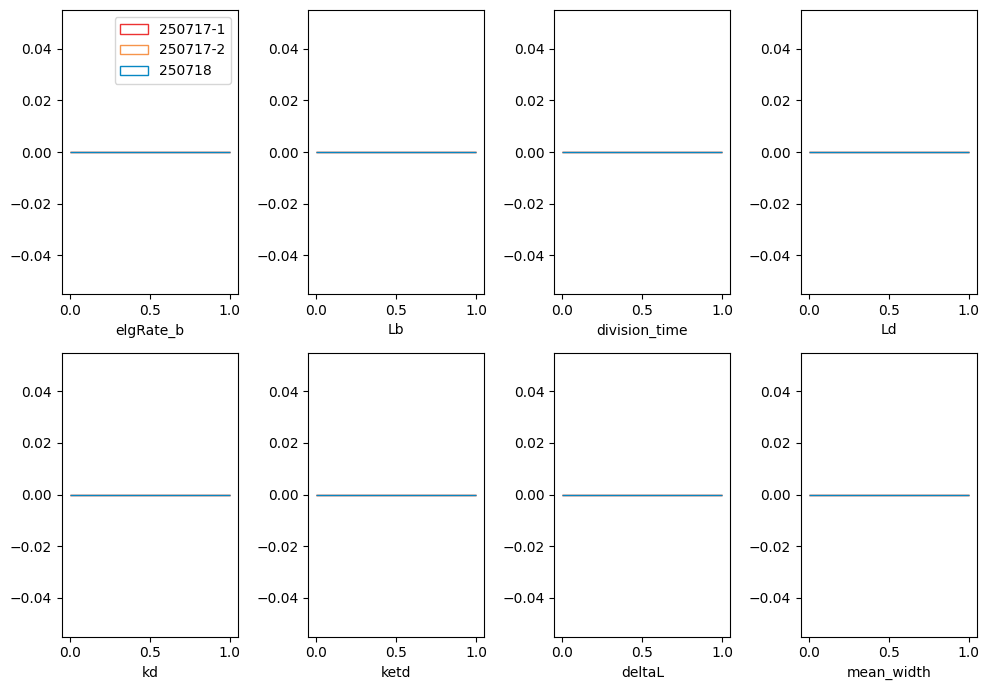

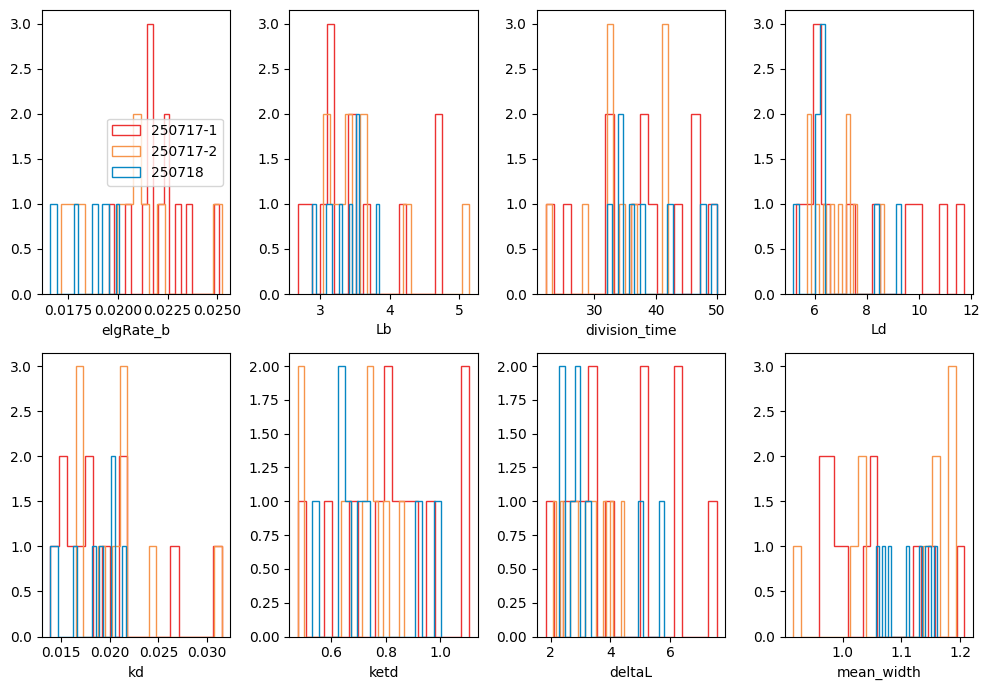

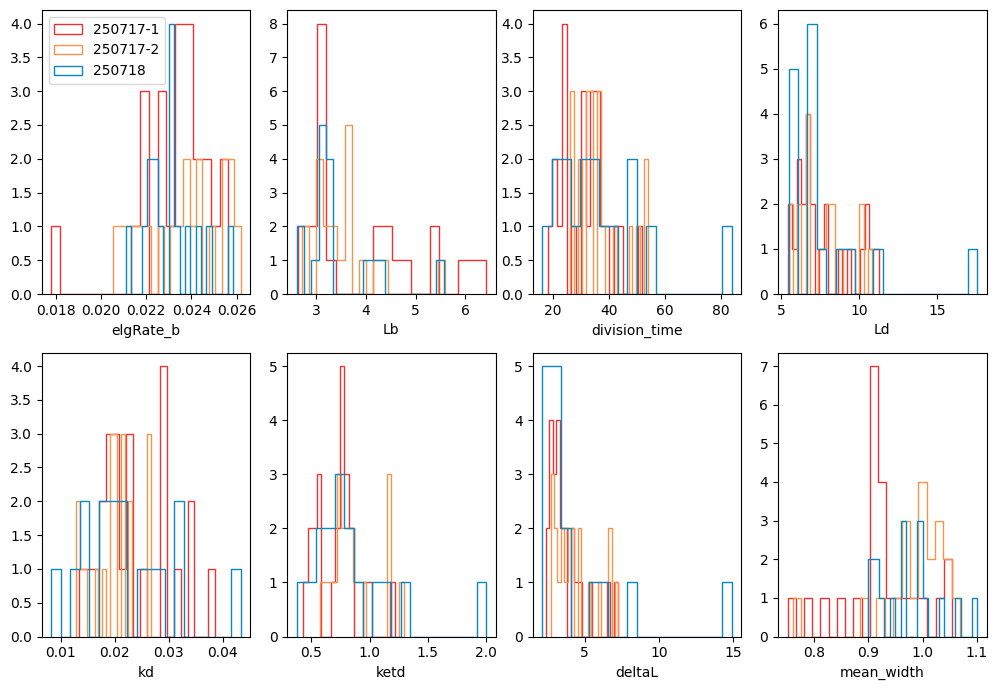

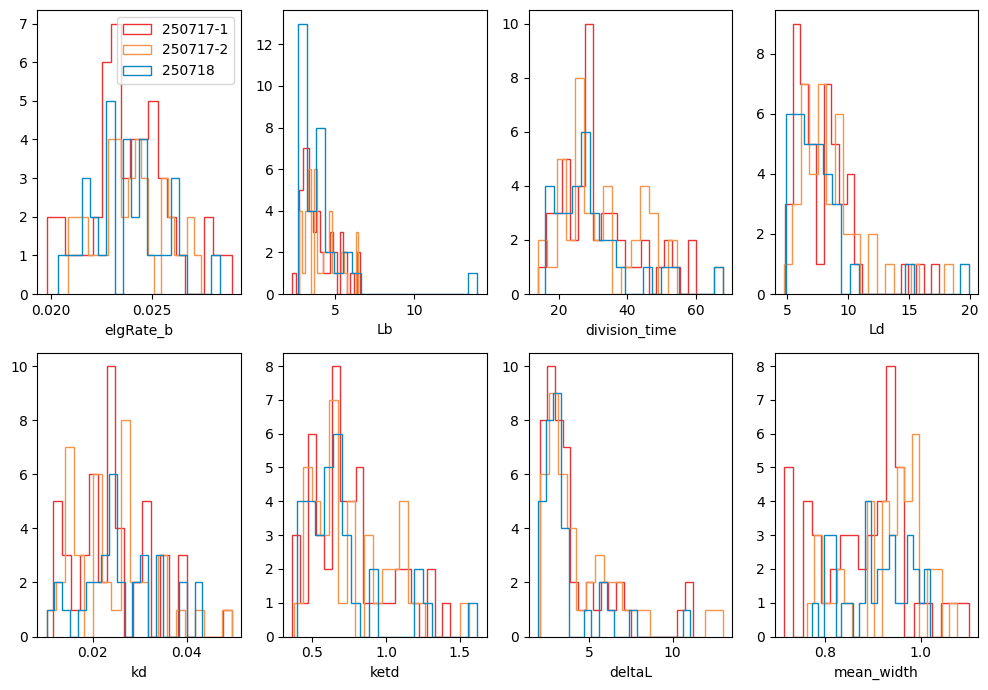

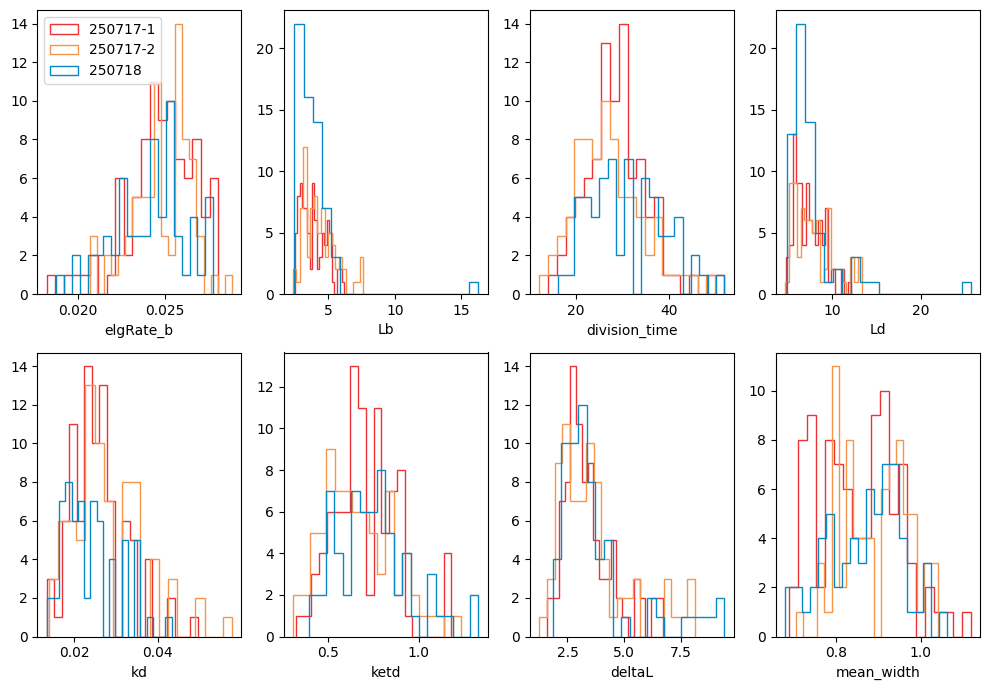

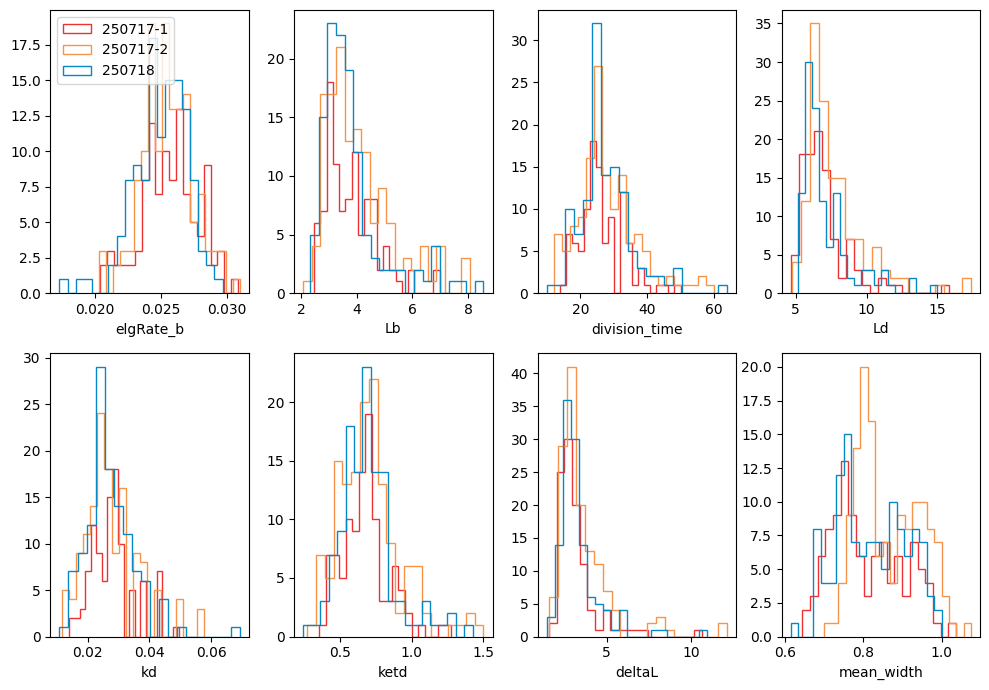

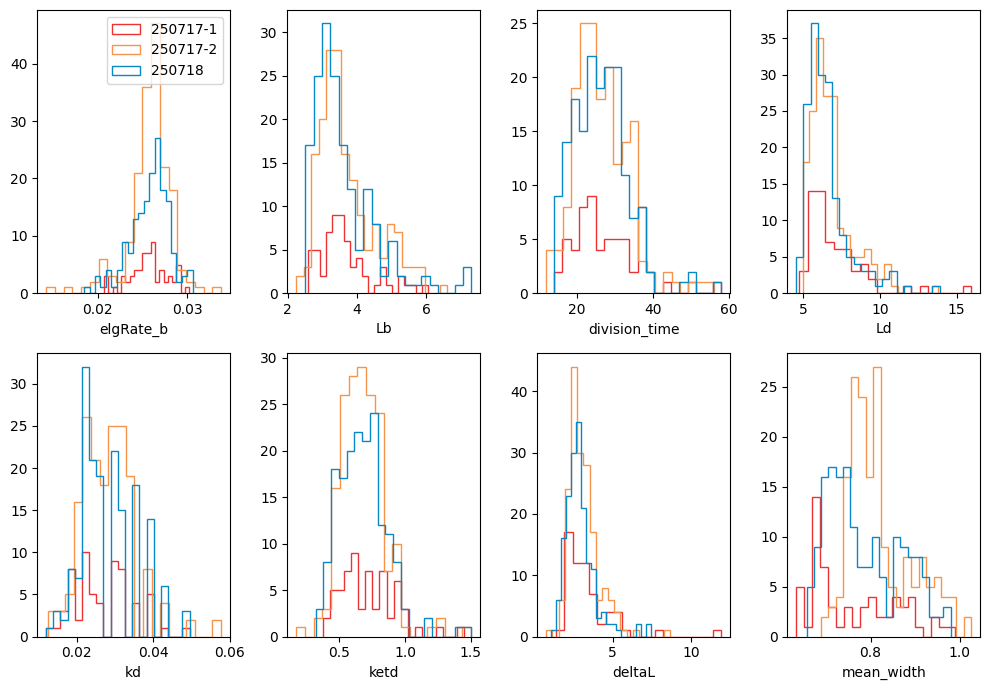

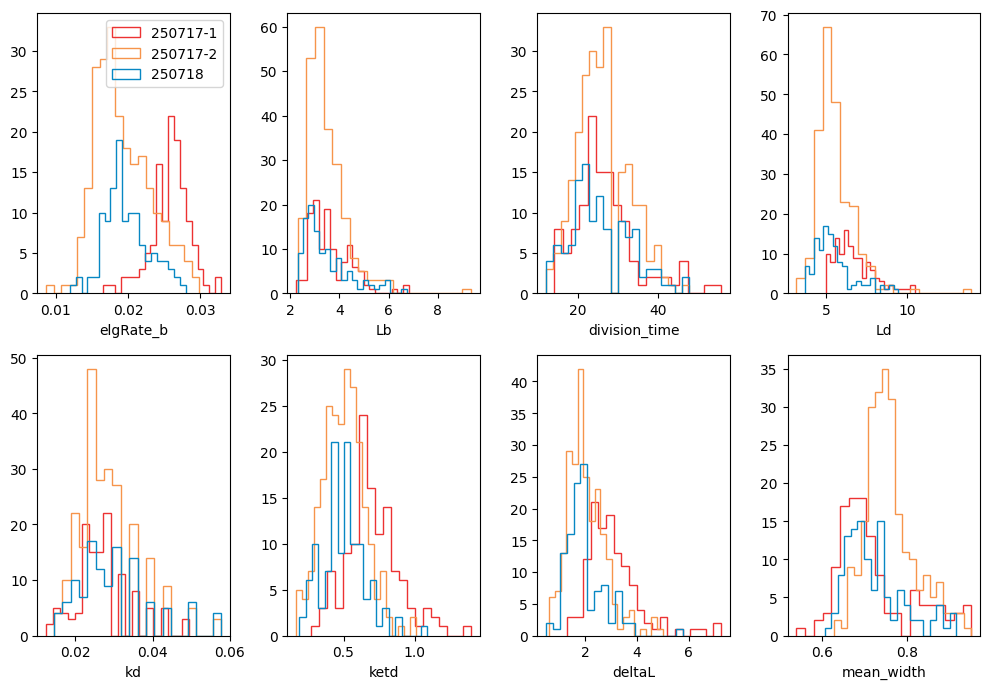

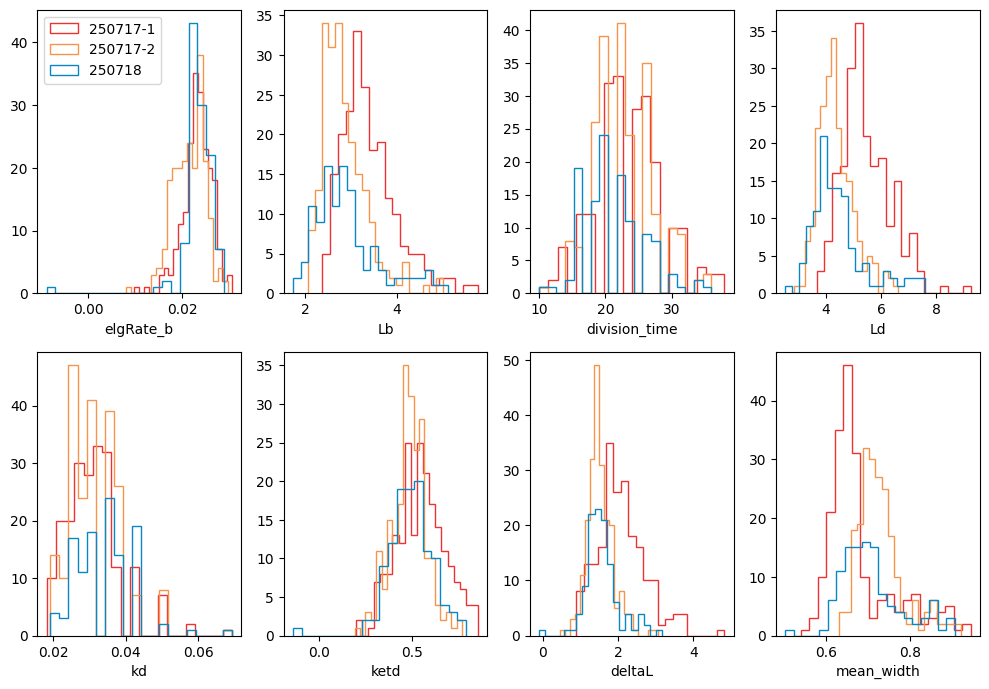

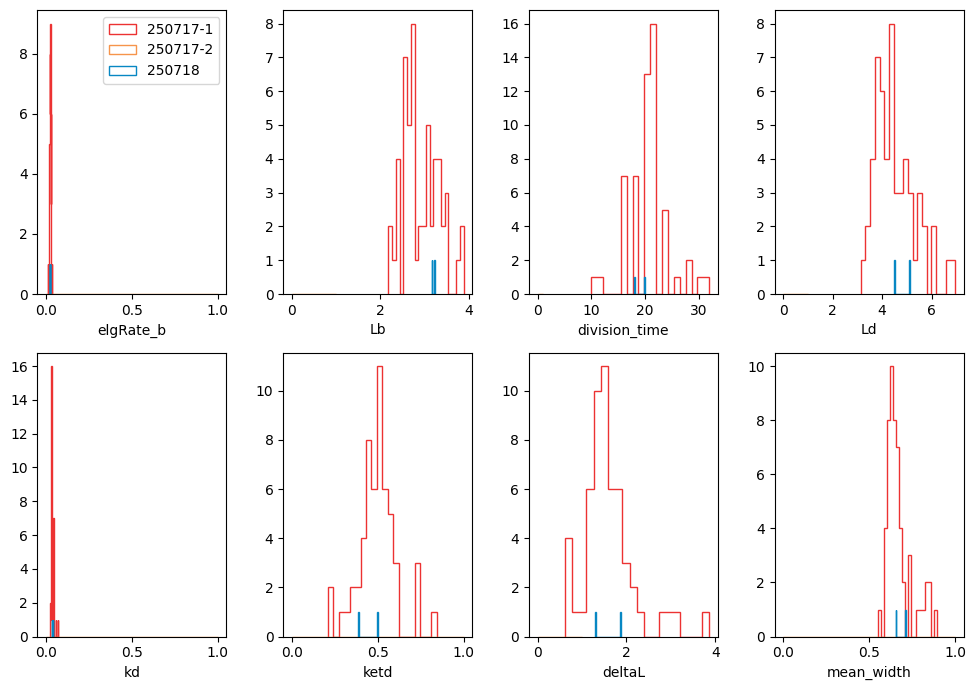

In [4]:
"""
histogram of all data, compare 4 biological replicas
(not rescaled)
-----input------
-elg-cv2_250628.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----
Histogram bin=20
'elgRate_b', 'Lb', 'division_time', 'Ld', 'kd', 'ketd', 'deltaL', 'mean_width'

""" 
# paths = [['ForPub/150-LBLMagar/240228-150-1-ana/00324'], ['ForPub/150-LBLMagar/250107-150-ana/00778'], 
#          ['ForPub/150-LBLMagar/250108-150-ana/00788'],['ForPub/150-LBLMagar/250606-150-ana/00909']]
# exppaths = ['ForPub/150-LBLMagar/240228-150-1-ana', 'ForPub/150-LBLMagar/250107-150-ana',
#            'ForPub/150-LBLMagar/250108-150-ana', 'ForPub/150-LBLMagar/250606-150-ana']
# labels = ['240228', '250107', '250108', '250606']

paths = [['ForPub/150-LBLMagar/250717-150-1-ana/00946'], ['ForPub/150-LBLMagar/250717-150-2-ana/00955'], 
         ['ForPub/150-LBLMagar/250718-150-ana/00957']]
exppaths = ['ForPub/150-LBLMagar/250717-150-1-ana', 'ForPub/150-LBLMagar/250717-150-2-ana',
           'ForPub/150-LBLMagar/250718-150-ana']
labels = ['250717-1', '250717-2', '250718']

plotpath = 'ForPub/150-LBLMagar/ForPub-plot/histograms-250728'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

col_name_list = ['elgRate_b', 'Lb', 'division_time', 'Ld', 'kd', 'ketd', 'deltaL', 'mean_width']
for gen in range(10):
    fig, ax =plt.subplots(2,4, figsize=(10, 7))
    for i in range(3):
        exppath = exppaths[i]
        rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
    #     rplcpathList = paths[i]
    #     print(labels[i])
        # concatenate dataFrame 
        df_concat = pd.DataFrame({})
        for rplcpath in sorted(rplcpathList):
            head, rplcIdx = os.path.split(rplcpath) 

            elgName = rplcIdx + '-elg-cv2_250628.csv' 
            df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
            # [cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
            df_concat = pd.concat([df_concat, df], ignore_index=True) 

        filtered = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                             & df_concat["Lb"].notna() & df_concat["Ld"].notna() #]
                             & (df_concat["generation"] == gen)] #filter for generation or time_start 

        valid = filtered.copy()
        valid['kd'] = np.log(2) /valid["division_time"]
        valid["ketd"] = valid["elgRate_b"] * valid["division_time"]
        valid["deltaL"] = valid["Ld"] - valid["Lb"] 
        for j in range(8):
            col_name = col_name_list[j]
            ax[j//4, j%4].hist(valid[col_name], bins=20, # density=True, 
                               color=colors_mid[i], label=labels[i], histtype='step')
            ax[j//4, j%4].set_xlabel(col_name)
    #         print(f"{col_name} mean: {valid[col_name].mean()}, std: {valid[col_name].std()}")

    handles, lbls = ax[0,0].get_legend_handles_labels()
    by_label = dict(zip(lbls, handles))
    ax[0,0].legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(plotpath, (f"Histogram_all_G{gen}.png")), dpi=300)

In [11]:
print(valid.head())

Empty DataFrame
Columns: [cell_ID, generation, time_start, mean_solidity, mean_width, Lb, Ld, elgRate_b, division_time, kd, ketd, deltaL, time_bin]
Index: []


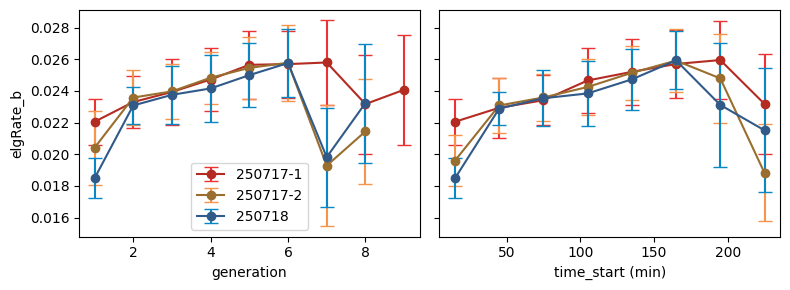

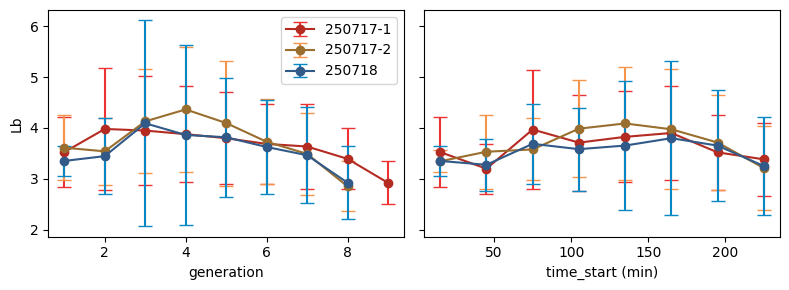

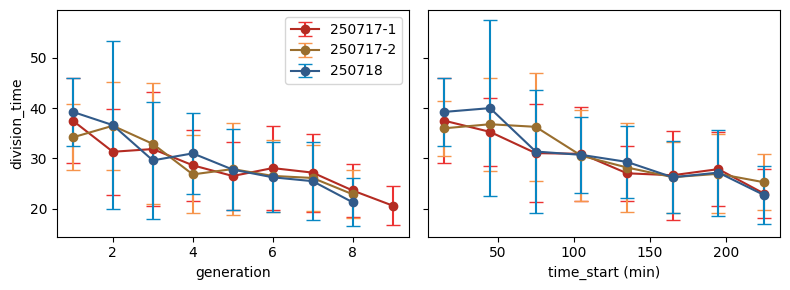

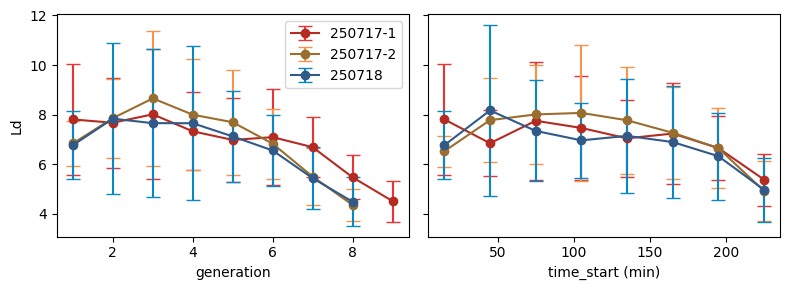

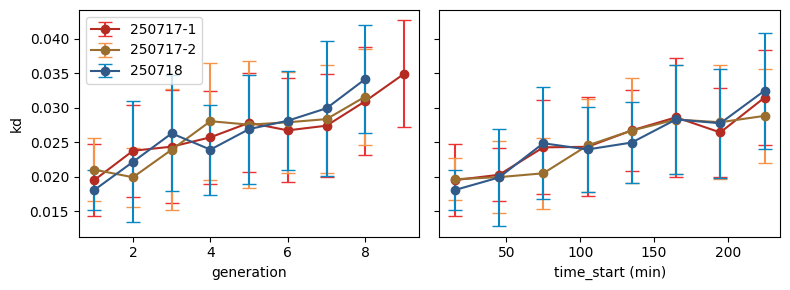

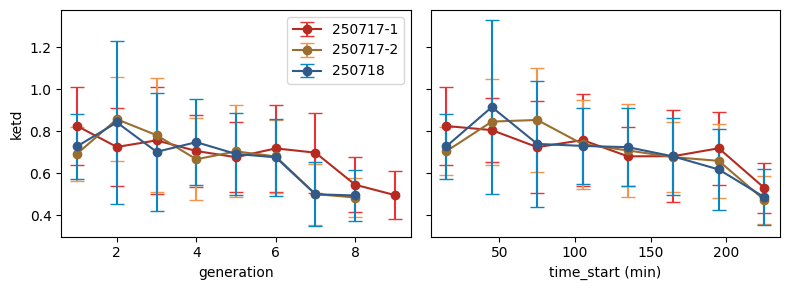

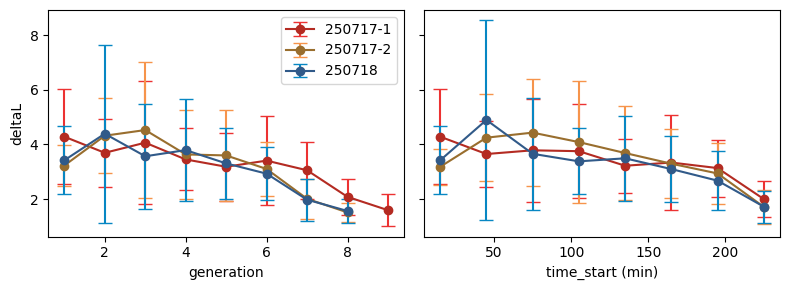

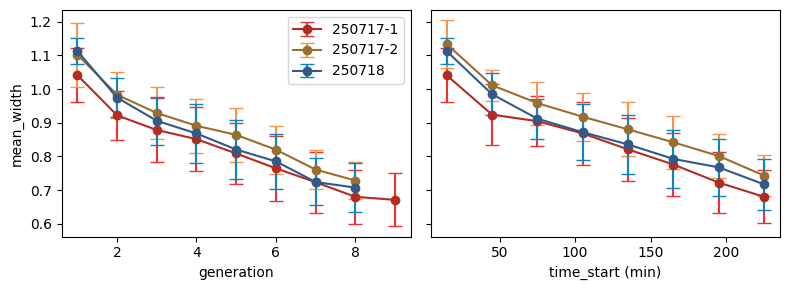

In [5]:
"""
mean-errorbar plot of all data, compare 4 biological replicas
to generation and to time

-----input------
-elg-cv2_250628.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----

'elgRate_b', 'Lb', 'division_time', 'Ld', 'kd', 'ketd', 'deltaL', 'mean_width'

""" 
# paths = [['ForPub/150-LBLMagar/240228-150-1-ana/00324'], ['ForPub/150-LBLMagar/250107-150-ana/00778'], 
#          ['ForPub/150-LBLMagar/250108-150-ana/00788'],['ForPub/150-LBLMagar/250606-150-ana/00909']]
# exppaths = ['ForPub/150-LBLMagar/240228-150-1-ana', 'ForPub/150-LBLMagar/250107-150-ana',
#            'ForPub/150-LBLMagar/250108-150-ana', 'ForPub/150-LBLMagar/250606-150-ana']
# labels = ['240228', '250107', '250108', '250606']

paths = [['ForPub/150-LBLMagar/250717-150-1-ana/00946'], ['ForPub/150-LBLMagar/250717-150-2-ana/00955'], 
         ['ForPub/150-LBLMagar/250718-150-ana/00957']]
exppaths = ['ForPub/150-LBLMagar/250717-150-1-ana', 'ForPub/150-LBLMagar/250717-150-2-ana',
           'ForPub/150-LBLMagar/250718-150-ana']
labels = ['250717-1', '250717-2', '250718']

plotpath = 'ForPub/150-LBLMagar/ForPub-plot/time_trend_250728'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

col_name_list = ['elgRate_b', 'Lb', 'division_time', 'Ld', 'kd', 'ketd', 'deltaL', 'mean_width']
time_bin = 30 # ca. a cell cycle
bins = np.arange(0, 270, time_bin)
time_mid = bins[:-1] + time_bin/2

for col_name in col_name_list:
    fig, ax =plt.subplots(1,2, figsize=(8, 3), sharey='row')

    for i in range(3):
        exppath = exppaths[i]
        rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
    #     rplcpathList = paths[i]

        # concatenate dataFrame 
        df_concat = pd.DataFrame({})
        for rplcpath in sorted(rplcpathList):
            head, rplcIdx = os.path.split(rplcpath) 

            elgName = rplcIdx + '-elg-cv2_250628.csv' 
            df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
            # [cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
            df_concat = pd.concat([df_concat, df], ignore_index=True) 

        filtered = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                             & df_concat["Lb"].notna() & df_concat["Ld"].notna() ]

        valid = filtered.copy()
        valid['kd'] = np.log(2) /valid["division_time"]
        valid["ketd"] = valid["elgRate_b"] * valid["division_time"]
        valid["deltaL"] = valid["Ld"] - valid["Lb"] 
    
        # Group by 'generation' and filter groups with more than 5 samples
        grouped = valid.groupby("generation")
        gen_stats = grouped[col_name].agg(['mean', 'std', 'count']).reset_index()
        gen_stats_f = gen_stats[gen_stats["count"] > 5]
    #     ax[0].scatter(gen_stats_f["generation"], gen_stats_f['mean'], color=colors_dark[i], label=labels[i])
        ax[0].errorbar(gen_stats_f["generation"], gen_stats_f["mean"], yerr=gen_stats_f["std"], fmt='o-', color=colors_dark[i], 
                           ecolor=colors_mid[i], capsize=5, label=labels[i])

        # bin by time and calculate mean and standard deviation
        valid['time_bin'] = pd.cut(valid['time_start'], bins=bins, labels=time_mid, right=False)

        # Group by 'time_bin' and filter groups with more than 5 samples
        grouped_t = valid.groupby("time_bin", observed=True)
        time_bin_stats = grouped_t[col_name].agg(['mean', 'std', 'count']).reset_index()
        time_bin_stats_f = time_bin_stats[time_bin_stats["count"] > 5]
    #     ax.scatter(time_bin_stats['time_bin'], time_bin_stats['mean'], color=colors_dark[i], label=labels[i])
        ax[1].errorbar(time_bin_stats_f["time_bin"], time_bin_stats_f["mean"], yerr=time_bin_stats_f["std"], fmt='o-', 
                       color=colors_dark[i], ecolor=colors_mid[i], capsize=5)

        ax[0].set_ylabel(col_name)
        ax[0].set_xlabel("generation")
        ax[0].legend()
        ax[1].set_xlabel("time_start (min)")
        plt.tight_layout()
    #     plt.show()
        plt.savefig(os.path.join(plotpath, (f"{col_name}_time_trend.png")), dpi=300)

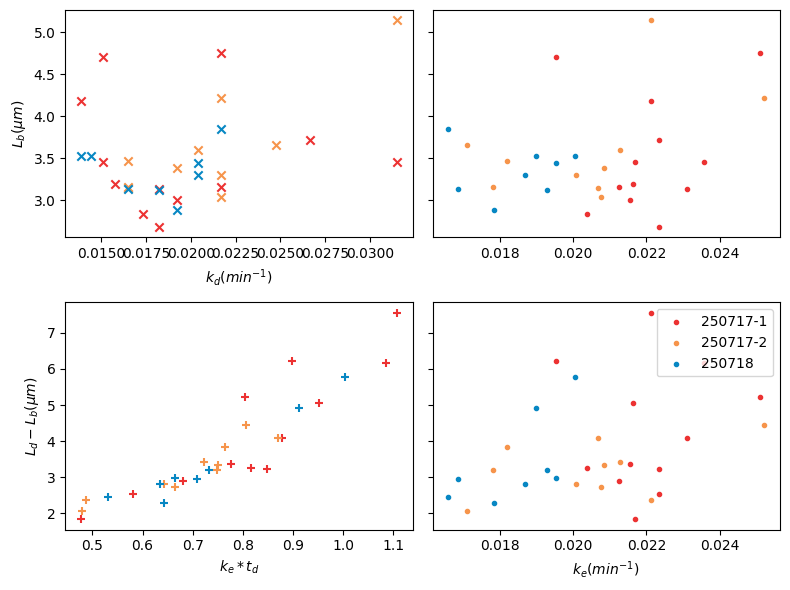

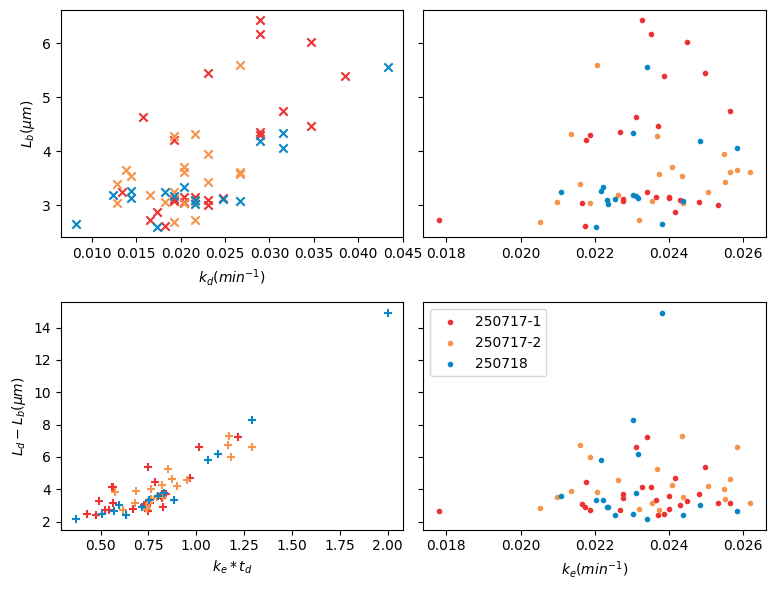

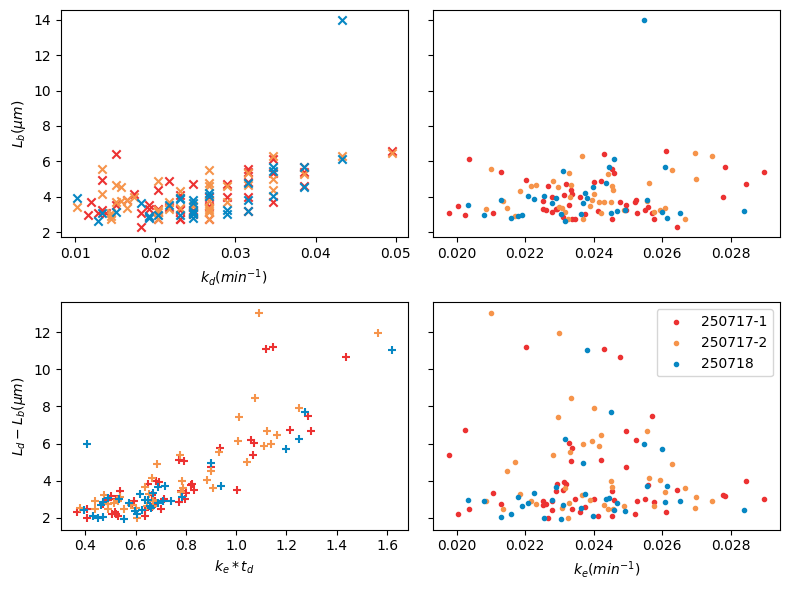

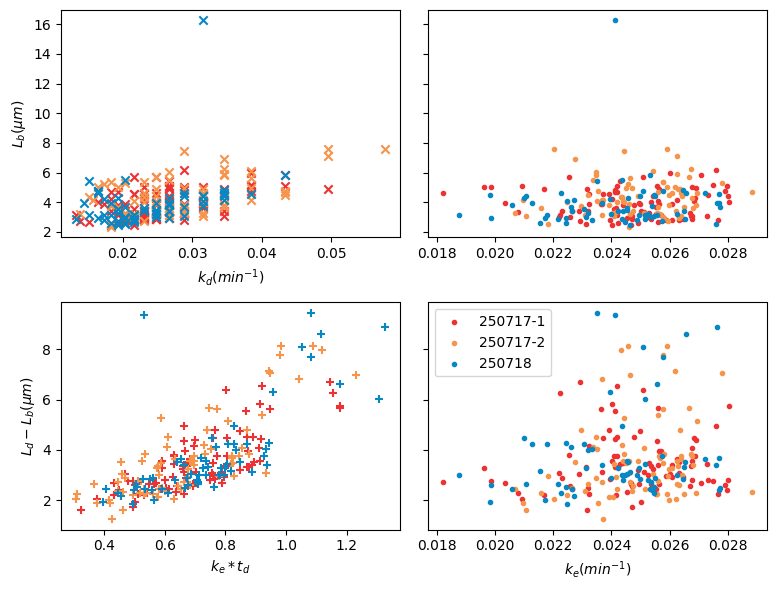

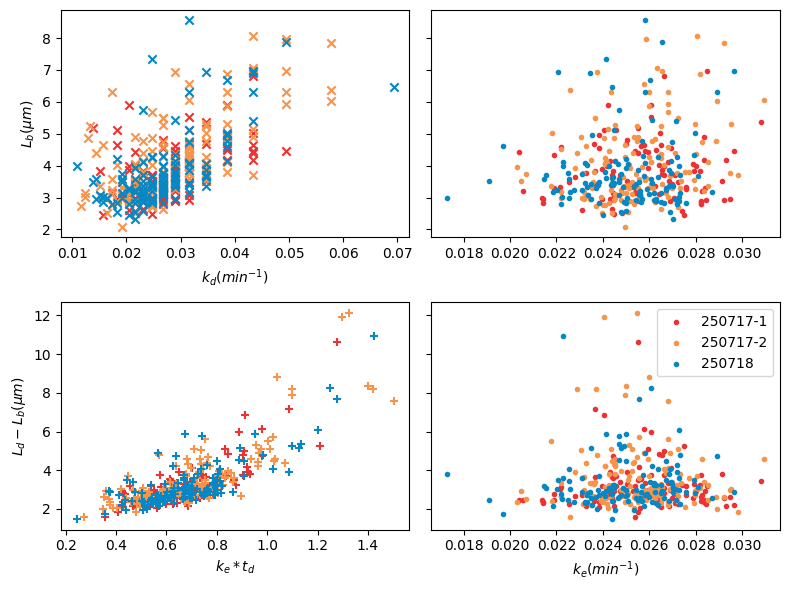

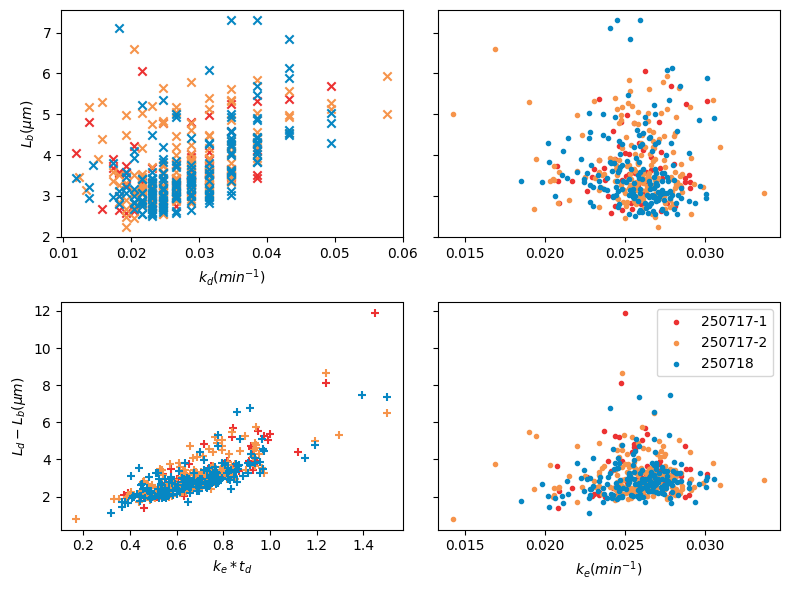

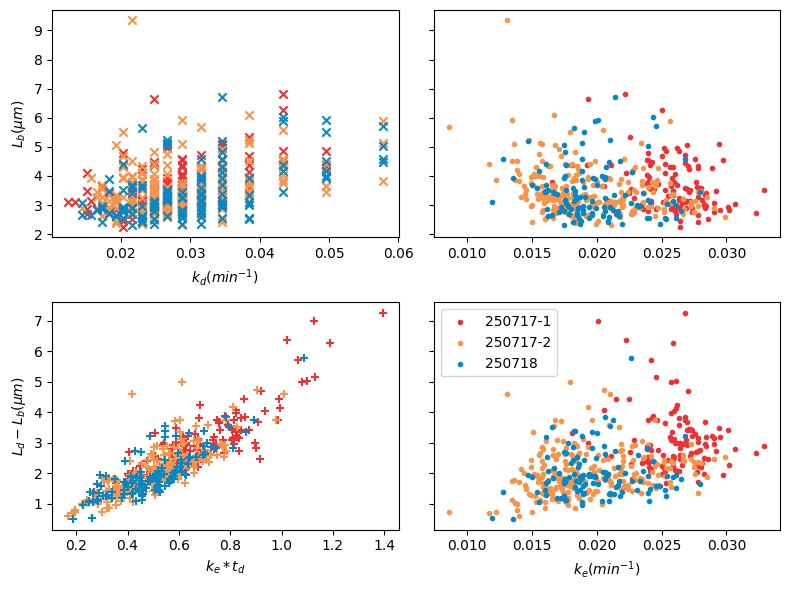

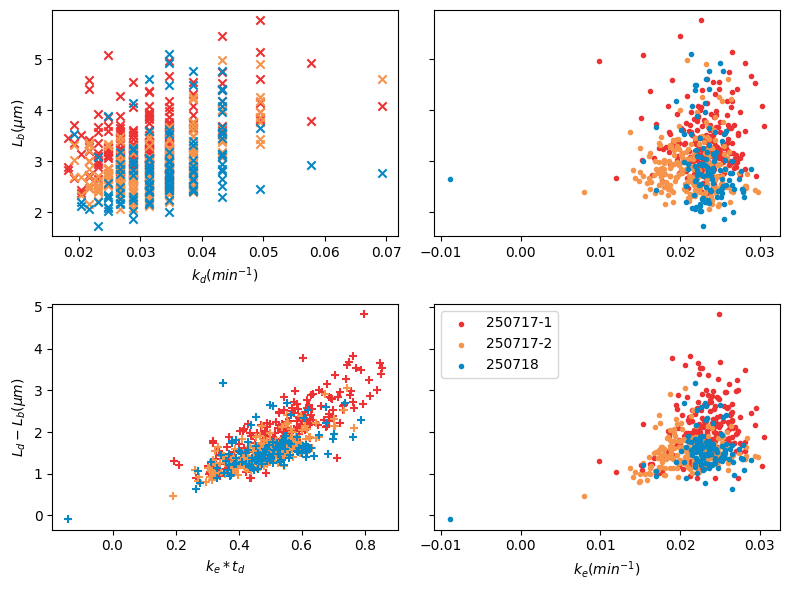

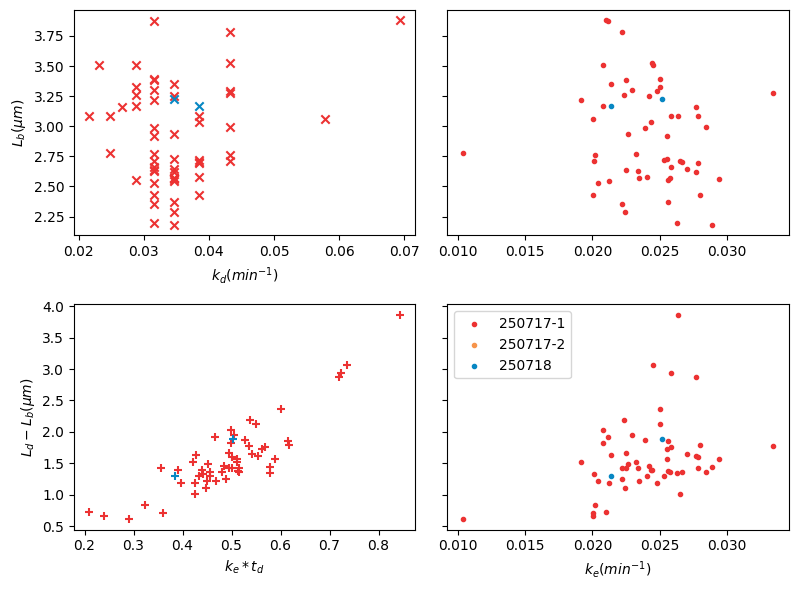

In [6]:
"""  
# all data, compare 4 biological replicas by generation
correlation between:
	Lb to ln2/td	Lb to elgRate=ke
	Ld-Lb to ketd	Ld-Lb to ke
 
-----input------
-elg-cv2_250628.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----
cross plot by generations

""" 

# paths = [['ForPub/150-LBLMagar/240228-150-1-ana/00324'], ['ForPub/150-LBLMagar/250107-150-ana/00778'], 
#          ['ForPub/150-LBLMagar/250108-150-ana/00788'],['ForPub/150-LBLMagar/250606-150-ana/00909']]
# exppaths = ['ForPub/150-LBLMagar/240228-150-1-ana', 'ForPub/150-LBLMagar/250107-150-ana',
#            'ForPub/150-LBLMagar/250108-150-ana', 'ForPub/150-LBLMagar/250606-150-ana']
# labels = ['240228', '250107', '250108', '250606']

paths = [['ForPub/150-LBLMagar/250717-150-1-ana/00946'], ['ForPub/150-LBLMagar/250717-150-2-ana/00955'], 
         ['ForPub/150-LBLMagar/250718-150-ana/00957']]
exppaths = ['ForPub/150-LBLMagar/250717-150-1-ana', 'ForPub/150-LBLMagar/250717-150-2-ana',
           'ForPub/150-LBLMagar/250718-150-ana']
labels = ['250717-1', '250717-2', '250718']

plotpath = 'ForPub/150-LBLMagar/ForPub-plot/correlations-250728'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)


# pearson_data = []
for gen in range(1,10):
    fig, ax =plt.subplots(2,2, figsize=(8, 6), sharey='row')

    for i in range(3):
        exppath = exppaths[i]
        rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
    #     rplcpathList = paths[i]
    #     print(labels[i])
        # concatenate dataFrame 
        df_concat = pd.DataFrame({})
        for rplcpath in sorted(rplcpathList):
            head, rplcIdx = os.path.split(rplcpath) 

            elgName = rplcIdx + '-elg-cv2_250628.csv' 
            df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
            # [cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
            df_concat = pd.concat([df_concat, df], ignore_index=True) 

        filtered = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                             & df_concat["Lb"].notna() & df_concat["Ld"].notna() #]
                             & (df_concat["generation"] == gen)] #filter for generation or time_start 

        valid = filtered.copy()
        valid['kd'] = np.log(2) /valid["division_time"]
        valid["ketd"] = valid["elgRate_b"] * valid["division_time"]
        valid["deltaL"] = valid["Ld"] - valid["Lb"] 
        
#         sample_size = len(valid)
#         if sample_size >=5:
#             corr_lb_kd, p_lb_kd = scipy.stats.pearsonr(valid['kd'], valid["Lb"])
#             corr_lb_ke, p_lb_ke = scipy.stats.pearsonr(valid["elgRate_b"], valid["Lb"])
#             corr_dl_ketd, p_dl_ketd = scipy.stats.pearsonr(valid["ketd"], valid["deltaL"])
#             corr_dl_ke, p_dl_ke = scipy.stats.pearsonr(valid["elgRate_b"], valid["deltaL"])
#         else:
#             corr_lb_kd, p_lb_kd = None, None
#             corr_lb_ke, p_lb_ke = None, None
#             corr_dl_ketd, p_dl_ketd = None, None
#             corr_dl_ke, p_dl_ke = None, None
           
        # Lb to ln2/td
        ax[0,0].scatter(valid['kd'], valid["Lb"], 
                        marker='x', color=colors_mid[i], label=labels[i])
        # Lb to elgRate=ke
        ax[0,1].scatter(valid["elgRate_b"], valid["Lb"], 
                        marker='.', color=colors_mid[i], label=labels[i])
        # Ld-Lb to ketd
        ax[1,0].scatter(valid["ketd"], valid["deltaL"], 
                        marker='+', color=colors_mid[i], label=labels[i])
        # Ld-Lb to ke
        ax[1,1].scatter(valid["elgRate_b"], valid["deltaL"], 
                        marker='.', color=colors_mid[i], label=labels[i])
            
#         pearson_data.append({
#             "generation": gen,
#             "agarose": c,
#             "corr_lb_kd": corr_lb_kd,
#             "p_lb_kd" : p_lb_kd,
#             "corr_lb_ke": corr_lb_ke,
#             "p_lb_ke" : p_lb_ke,
#             "corr_dl_ketd": corr_dl_ketd,
#             "p_dl_ketd" : p_dl_ketd,
#             "corr_dl_ke": corr_dl_ke,
#             "p_dl_ke" : p_dl_ke,
#             "sample_size": sample_size
#         })
        
    ax[0,0].set_ylabel(r"$ L_b (\mu m) $")
    ax[0,0].set_xlabel(r"$ k_d (min^{-1}) $")
    ax[1,0].set_xlabel(r"$ k_e (min^{-1}) $")
#     ax[1,0].set_xlim(0.01, 0.08)

    ax[1,0].set_ylabel(r"$ L_d- L_b (\mu m)  $")
    ax[1,0].set_xlabel(r"$ k_e * t_d $")
    ax[1,1].set_xlabel(r"$ k_e (min^{-1})  $")
#     ax[1,1].set_xlim(1, 10)
    
    plt.legend()
    plt.tight_layout()
#     plt.show()
    plt.savefig(os.path.join(plotpath, f"2-elgRT_crossplot_gen{gen}.png")) 


# df = pd.DataFrame(pearson_data)
# # df.to_csv(os.path.join(plotpath, "pearson_corr_gen.csv"), index=False)
# df_sorted = df.sort_values(by='agarose')
# for agarose_val, group_df in df_sorted.groupby('agarose'):
#     group_df_sorted = group_df.sort_values("generation")
#     filename = f"{agarose_val}pearson_corr_gen_2.csv"
#     group_df_sorted.to_csv(os.path.join(plotpath,filename), index=False)


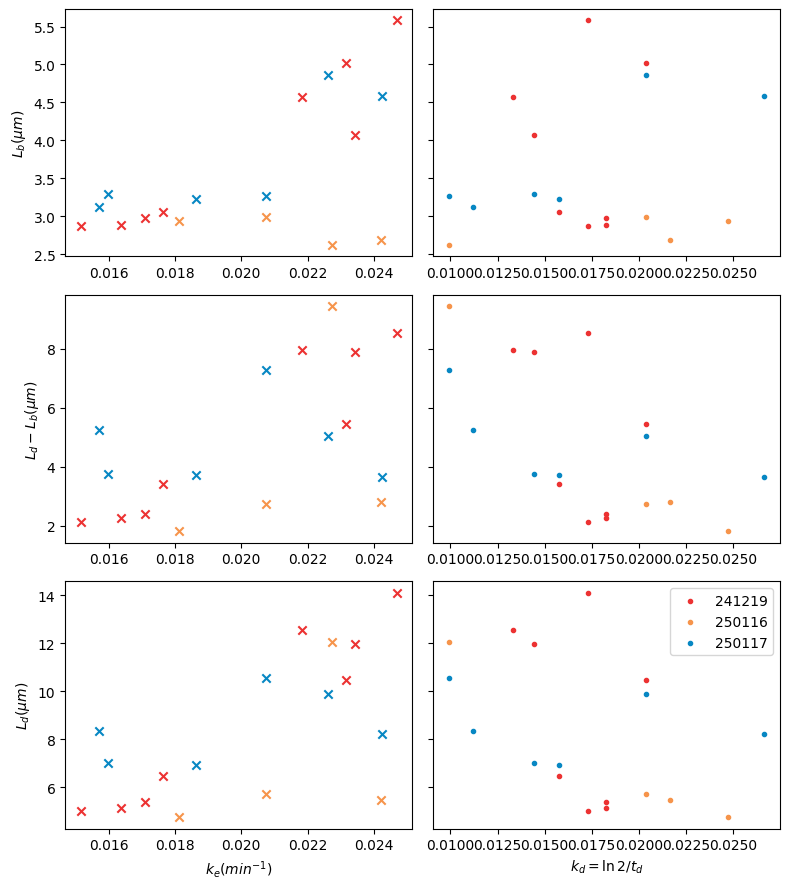

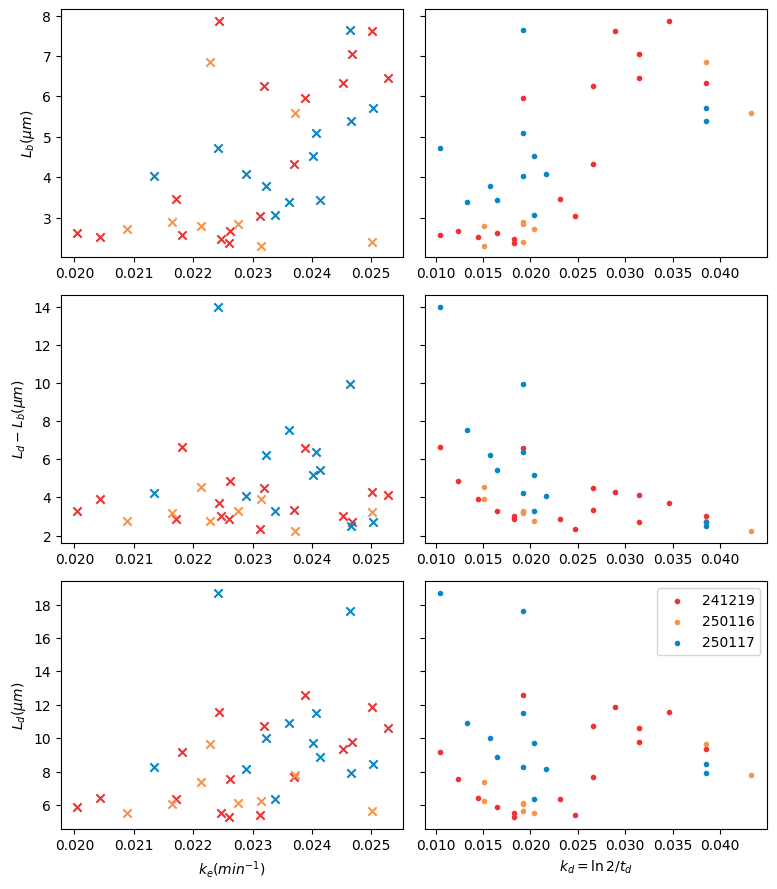

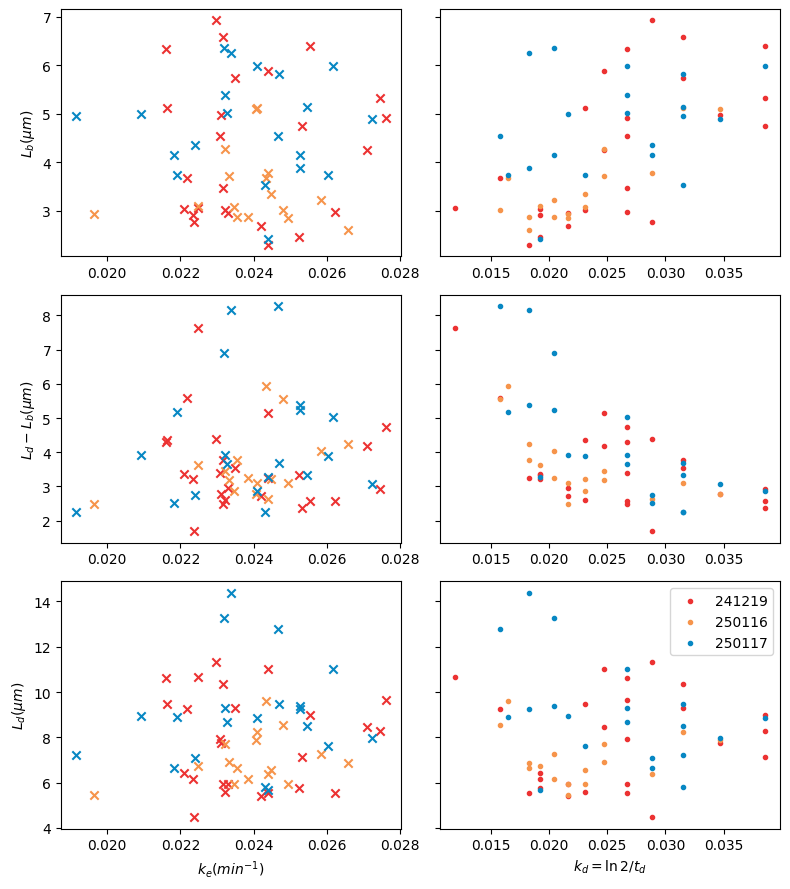

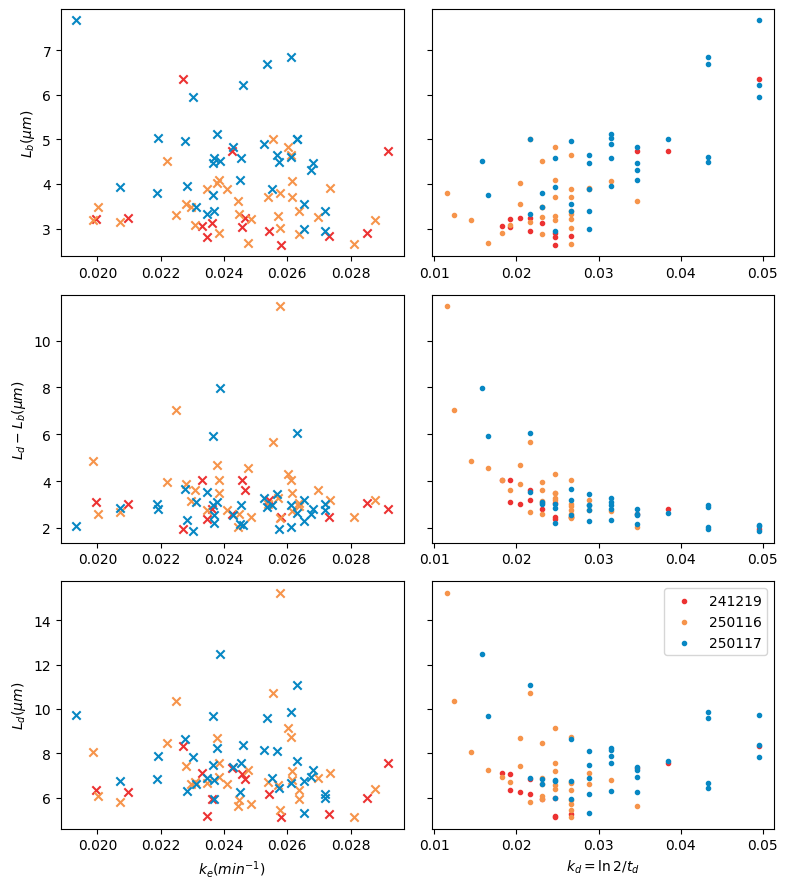

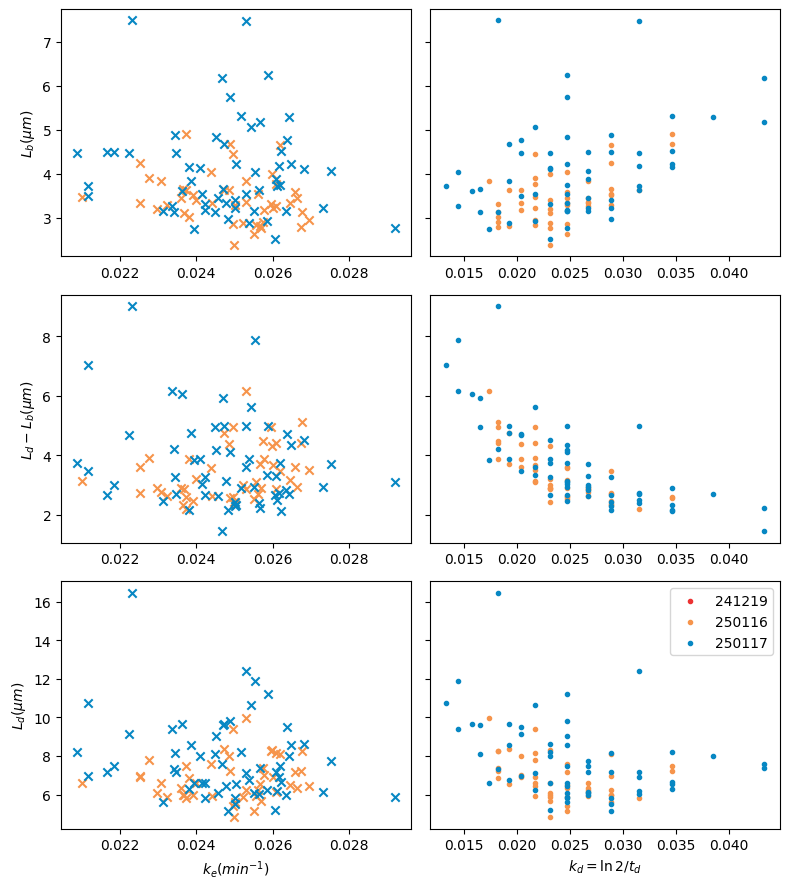

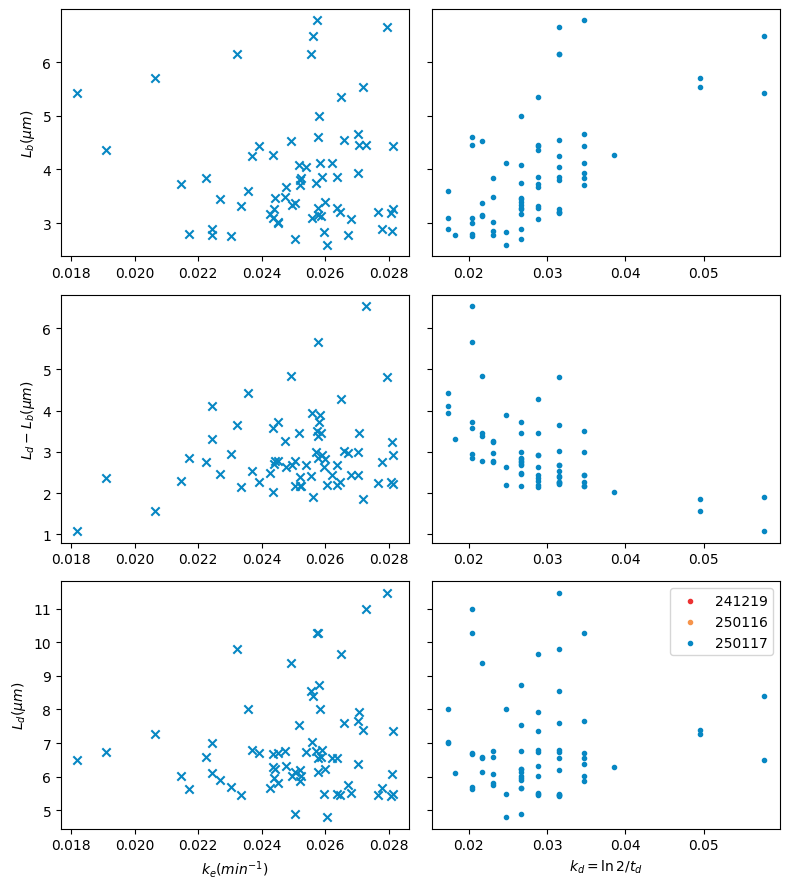

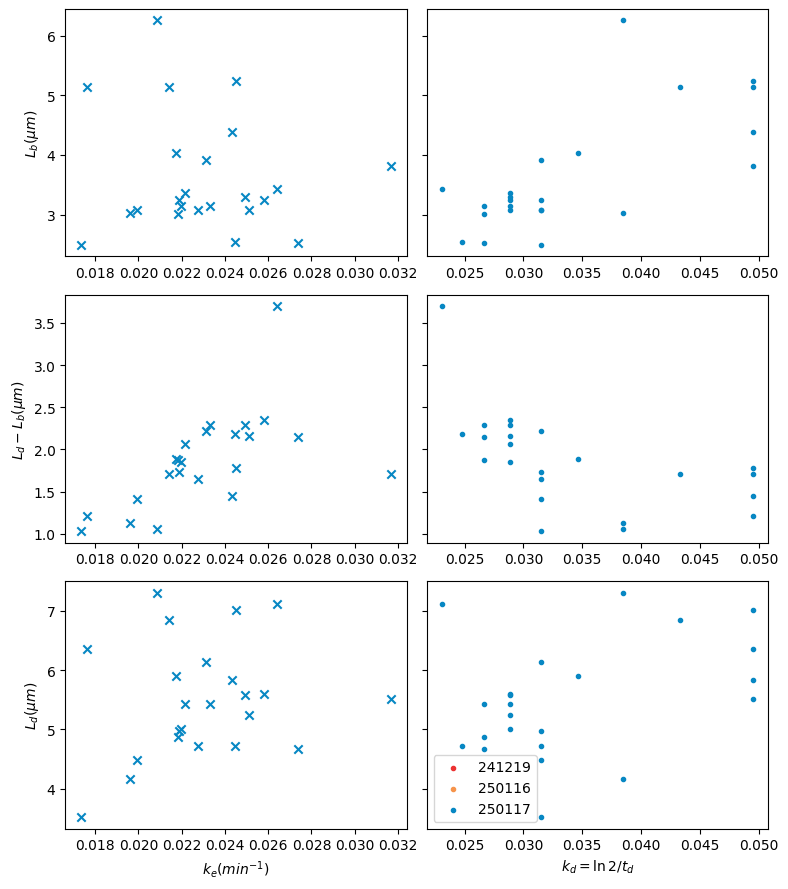

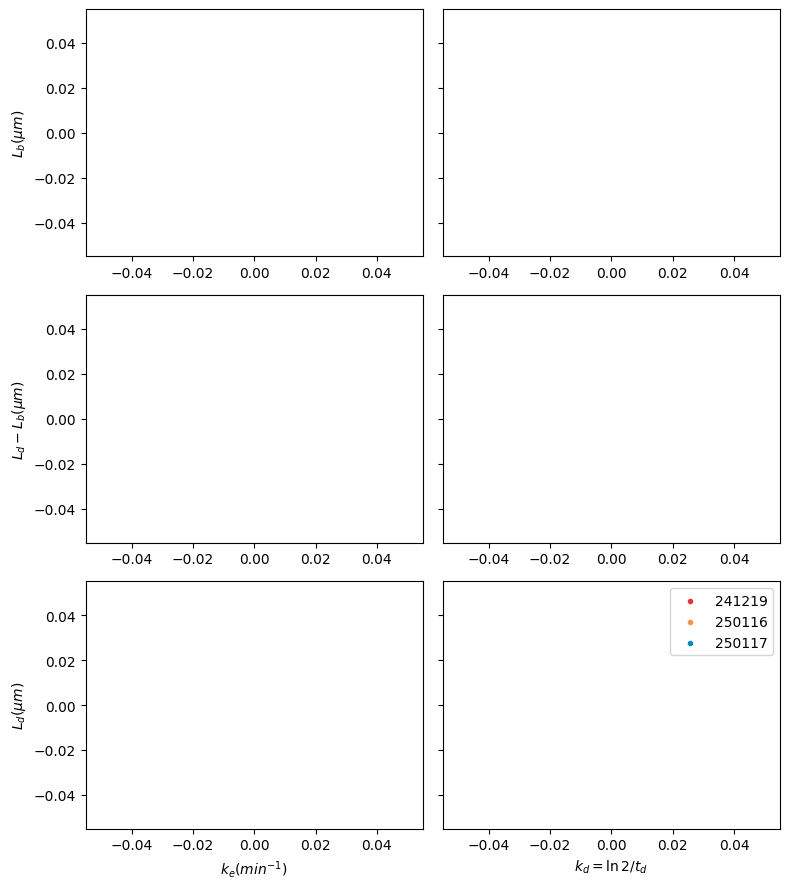

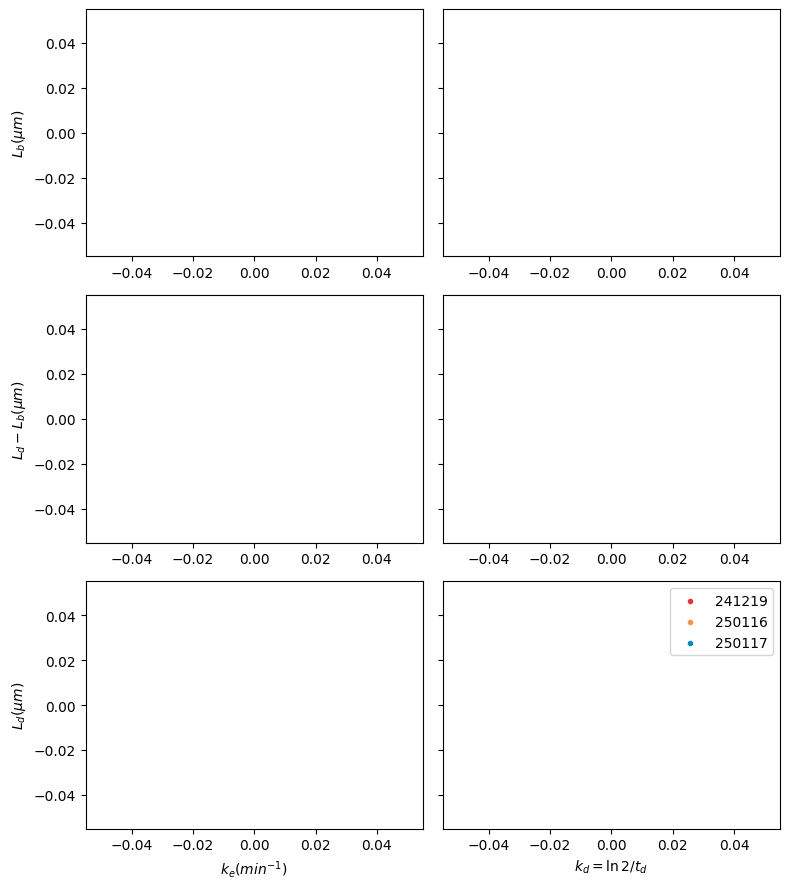

In [7]:
"""  
# all data, compare 4 biological replicas by generation
correlation between:
	[Lb, Ld-Lb, Ld] to [ke, kd]   # kd=ln2/"division_time", ke:= "elgRate_b"

	[Lb, Ld-Lb, Ld] to [ln2/td, td]
	[Lb, Ld-Lb, Ld] to [ketd, ke]
 
-----input------
-elg-cv2_250628.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----
cross plot by generations

""" 

# exppaths = ['ForPub/150-LBLMagar/240228-150-1-ana', 'ForPub/150-LBLMagar/250107-150-ana',
#            'ForPub/150-LBLMagar/250108-150-ana', 'ForPub/150-LBLMagar/250606-150-ana']
# labels = ['240228', '250107', '250108', '250606']

exppaths = ['ForPub/075-LBLMagar/241219-075-ana', 'ForPub/075-LBLMagar/250116-075-ana',
           'ForPub/075-LBLMagar/250117-075-2-ana', 'ForPub/075-LBLMagar/backups-cellAna']
labels = ['241219', '250116', '250117', 'backups']

plotpath = 'ForPub/075-LBLMagar/ForPub-plot/correlations'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)


# pearson_data = []
for gen in range(1,10):
    fig, ax =plt.subplots(3,2, figsize=(8, 9), sharey='row')

    for i in range(3):
        exppath = exppaths[i]
        rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
    #     rplcpathList = paths[i]
    #     print(labels[i])
        # concatenate dataFrame 
        df_concat = pd.DataFrame({})
        for rplcpath in sorted(rplcpathList):
            head, rplcIdx = os.path.split(rplcpath) 

            elgName = rplcIdx + '-elg-cv2_250628.csv' 
            df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
            # [cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]
            df_concat = pd.concat([df_concat, df], ignore_index=True) 

        filtered = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                             & df_concat["Lb"].notna() & df_concat["Ld"].notna() #]
                             & (df_concat["generation"] == gen)] #filter for generation or time_start 

        valid = filtered.copy()
        valid['kd'] = np.log(2) /valid["division_time"]
        valid["ketd"] = valid["elgRate_b"] * valid["division_time"]
        valid["deltaL"] = valid["Ld"] - valid["Lb"] 
        
           
        # Lb to kd=ln2/td
        ax[0,0].scatter(valid['elgRate_b'], valid["Lb"], 
                        marker='x', color=colors_mid[i], label=labels[i])
        # Lb to td
        ax[0,1].scatter(valid["kd"], valid["Lb"], 
                        marker='.', color=colors_mid[i], label=labels[i])
        # Ld-Lb to kd
        ax[1,0].scatter(valid["elgRate_b"], valid["deltaL"], 
                        marker='x', color=colors_mid[i], label=labels[i])
        # Ld-Lb to td
        ax[1,1].scatter(valid["kd"], valid["deltaL"], 
                        marker='.', color=colors_mid[i], label=labels[i])
        # Ld to kd
        ax[2,0].scatter(valid["elgRate_b"], valid["Ld"], 
                        marker='x', color=colors_mid[i], label=labels[i])
        # Ld to td
        ax[2,1].scatter(valid["kd"], valid["Ld"], 
                        marker='.', color=colors_mid[i], label=labels[i])
        
    ax[0,0].set_ylabel(r"$ L_b (\mu m) $")
    ax[1,0].set_ylabel(r"$ L_d- L_b (\mu m)  $")  
    ax[2,0].set_ylabel(r"$ L_d (\mu m)  $")

    ax[2,0].set_xlabel(r"$ k_e (min^{-1})$")
    ax[2,1].set_xlabel(r"$ k_d= \ln 2/t_d$")
#     ax[1,1].set_xlim(1, 10)
    
    plt.legend()
    plt.tight_layout()
#     plt.show()
    plt.savefig(os.path.join(plotpath, f"Lbkekd_crossplot_gen{gen}.png")) 


In [21]:
"""  
# by generation
correlation between:
<elgRate> to 1/<td>  <elgRate * td> to <Lb>
<Lb> to 1/<td>   <elgRate> to <Lb>  
 
-----input------
-elg-cv2.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
cell_ID,generation,time_start
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----
cross plot by generations
Pearson corr 

""" 
pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}

plotpath = 'ForPub/ForPub-plot/elgRate-corr-250706/'

c_list = ['075', '150', '300', '600']
labels = ['0.75%', '1.5%', '3%', '6%']

pearson_data = []
for gen in range(1,9):
    fig, ax =plt.subplots(2,2, figsize=(8, 6), sharex='col')

    for i in range(4):
        c = list(pathDict.keys())[i]  # '075'
        paths = pathDict[c]  # path list

        # concatenate dataFrame for mean and std calculation
        df_concat = pd.DataFrame({})
        for j in range(len(paths)):
            path = paths[j]
            rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
            head, rplcIdx = os.path.split(rplcpath) 
            elgName = rplcIdx + '-elg-cv2_250628.csv' 
            df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
            # [cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
            df_concat = pd.concat([df_concat, df], ignore_index=True) 

            valid = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                              & df_concat["Lb"].notna() & (df_concat["generation"]==gen) ]

        sample_size = len(valid)
        if sample_size >=5:
            corr_ke_td, p_ke_td = scipy.stats.pearsonr(1/valid["division_time"], valid["elgRate_b"])
            corr_lb_ketd, p_lb_ketd = scipy.stats.pearsonr(valid["Lb"], valid["division_time"]*valid["elgRate_b"])
            corr_lb_td, p_lb_td = scipy.stats.pearsonr(1/valid["division_time"], valid["Lb"])
            corr_lb_ke, p_lb_ke = scipy.stats.pearsonr(valid["Lb"], valid["elgRate_b"])
        else:
            corr_ke_td, p_ke_td = None, None
            corr_lb_ketd, p_lb_ketd = None, None
            corr_lb_td, p_lb_td = None, None
            corr_lb_ke, p_lb_ke = None, None
           
        # <elgRate> to 1/<td>
        ax[0,0].scatter(1/valid["division_time"], valid["elgRate_b"], 
                        marker='x', color=colors_mid[i], label=labels[i])
        # <elgRate * td> to <Lb>
        ax[0,1].scatter(valid["Lb"], valid["division_time"]*valid["elgRate_b"], 
                        marker='.', color=colors_mid[i], label=labels[i])
        # <Lb> to 1/<td>
        ax[1,0].scatter(1/valid["division_time"], valid["Lb"], 
                        marker='+', color=colors_mid[i], label=labels[i])
        # <elgRate> to <Lb>
        ax[1,1].scatter(valid["Lb"], valid["elgRate_b"], 
                        marker='.', color=colors_mid[i], label=labels[i])
            
        pearson_data.append({
            "generation": gen,
            "agarose": c,
            "corr_ke_td": corr_ke_td,
            "p_ke_td" : p_ke_td,
            "corr_lb_ketd": corr_lb_ketd,
            "p_lb_ketd" : p_lb_ketd,
            "corr_lb_td": corr_lb_td,
            "p_lb_td" : p_lb_td,
            "corr_lb_ke": corr_lb_ke,
            "p_lb_ke" : p_lb_ke,
            "sample_size": sample_size
        })
        
    ax[0,0].set_ylabel(r"$ k_e (min^{-1}) $")
    ax[1,0].set_ylabel(r"$ L_b (\mu m) $")
    ax[1,0].set_xlabel(r"$1/t_d (min^{-1}) $")
    ax[1,0].set_xlim(0.01, 0.08)

    ax[0,1].set_ylabel(r"$k_e t_d $")
    ax[1,1].set_ylabel(r"$k_e (min^{-1})e$")
    ax[1,1].set_xlabel(r"$L_b (\mu m) $")
    ax[1,1].set_xlim(1, 10)
    
    plt.legend()
    plt.tight_layout()
#     plt.show()
    plt.savefig(os.path.join(plotpath, f"elgRT_crossplot_gen{gen}.png")) 


df = pd.DataFrame(pearson_data)
# df.to_csv(os.path.join(plotpath, "pearson_corr_gen.csv"), index=False)
df_sorted = df.sort_values(by='agarose')
for agarose_val, group_df in df_sorted.groupby('agarose'):
    group_df_sorted = group_df.sort_values("generation")
    filename = f"{agarose_val}pearson_corr_gen.csv"
    group_df_sorted.to_csv(os.path.join(plotpath,filename), index=False)


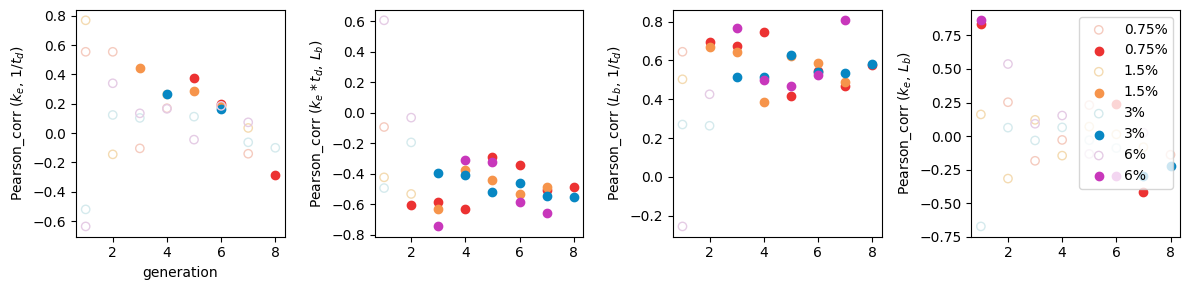

In [27]:
"""plot Pearson corr to time
generation,agarose,"corr_ke_td","p_ke_td","corr_lb_ketd","p_lb_ketd","corr_lb_td","p_lb_td","corr_lb_ke","p_lb_ke",sample_size

"""
plotpath = 'ForPub/ForPub-plot/elgRate-corr-250706/'
c_list = ['075', '150', '300', '600']
labels = ['0.75%', '1.5%', '3%', '6%']

corr_list =["corr_ke_td","corr_lb_ketd","corr_lb_td","corr_lb_ke"]
p_list = ["p_ke_td","p_lb_ketd","p_lb_td","p_lb_ke"]

fig, ax =plt.subplots(1,4, figsize=(12, 3))
ax[0].set_ylabel(r"Pearson_corr $(k_e, \, 1/t_d)$")  # <elgRate> to 1/<td>
ax[1].set_ylabel(r"Pearson_corr $(k_e*t_d, \, L_b)$")  # <elgRate * td> to <Lb>
ax[2].set_ylabel(r"Pearson_corr $(L_b, \, 1/t_d)$") # <Lb> to 1/<td>
ax[3].set_ylabel(r"Pearson_corr $(k_e, \, L_b)$") # <elgRate> to <Lb>
ax[0].set_xlabel("generation")

for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    filename = f"{c}pearson_corr_gen.csv"
    df = pd.read_csv(os.path.join(plotpath, filename), header=0)
    for j in range(4):
        df_corr = df[(df[p_list[j]] < 0.05)]
        df_non_corr = df[(df[p_list[j]] >= 0.05)]
        ax[j].scatter(df_non_corr["generation"], df_non_corr[corr_list[j]], marker='o', 
                      facecolors='none', edgecolors=colors_light[i])   
        ax[j].scatter(df_corr["generation"], df_corr[corr_list[j]], marker='o', color=colors_mid[i], label=labels[i])

plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(plotpath, "Pearson_corr_gen.svg"))

In [27]:
"""Histogram pre + mean/std, generation 4567
elgRate, td, Lb, Ld, Ld-Lb, ketd

-----input------
-elg-cv2.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
cell_ID,generation,time_start
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----

print mean, std
"""
pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}
c_list = ['075', '150', '300', '600']
labels = ['0.75%', '1.5%', '3%', '6%']
colname_list = ["elgRate_b", "division_time", "kd", "Lb", "Ld", "dL", "ketd"]
print(colname_list)

for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    print (c)
    
    # concatenate dataFrame for mean and std calculation
    df_concat = pd.DataFrame({})
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
        head, rplcIdx = os.path.split(rplcpath) 
        elgName = rplcIdx + '-elg-cv2_250628.csv' 
        df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
        # [cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
        df_concat = pd.concat([df_concat, df], ignore_index=True) 
        
    valid = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                      & df_concat["Lb"].notna() & (df_concat["generation"]> 3) & (df_concat["generation"]< 8)]  
    #last filter for generation or time_start  & (df_concat["generation"]==8)
    valid["ketd"] = valid["elgRate_b"] * valid["division_time"]
    valid["dL"] = valid["Ld"] - valid["Lb"]
    valid["kd"] = np.log(2)/ valid["division_time"]
    mean_list=[]
    for k in range(len(colname_list)):
#             valid_stats = valid[colname_list[k]].agg(['mean', 'std', 'count']).reset_index()
        mean_list.append(valid[colname_list[k]].mean())
    print(np.array(mean_list))
            
                     
#         grouped = df_concat.groupby("generation")
#         gen_stats = grouped[col_name].agg(['mean', 'std', 'count']).reset_index() 

['elgRate_b', 'division_time', 'kd', 'Lb', 'Ld', 'dL', 'ketd']
075
[ 0.0246 28.6794  0.0258  3.5947  6.7779  3.1833  0.704 ]
150
[ 0.024  29.5211  0.0253  3.5942  6.8815  3.2873  0.7056]
300
[ 0.0236 30.0594  0.0245  3.146   5.9425  2.7965  0.7072]
600
[ 0.0232 29.3246  0.0252  2.9177  5.3875  2.4697  0.6787]


C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_20676\910886722.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["ketd"] = valid["elgRate_b"] * valid["division_time"]
C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_20676\910886722.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["dL"] = valid["Ld"] - valid["Lb"]
C:\Users\chenyu.jin\AppData\Local\Temp\ipykernel_20676\910886722.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [9]:
print(np.array(mean_list))

[ 0.0232 29.3246  2.9177  5.3875  2.4697  0.6787]


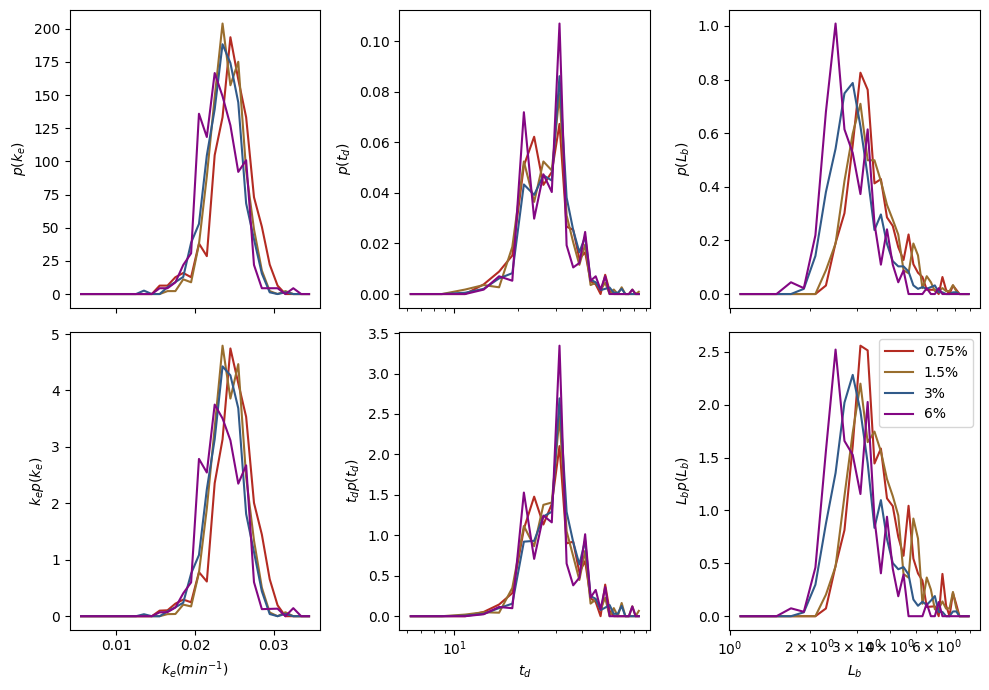

In [17]:
"""
histogram plot all data (not rescaled)
elgRate, td, Lb
ke*p(ke), td*p(td), Lb*p(Lb)

""" 


plotpath = 'ForPub/ForPub-plot/elgRate-250702/'
fig, ax =plt.subplots(2,3, figsize=(10, 7), sharex='col')

c_list = ['075', '150', '300', '600']
labels = ['0.75%', '1.5%', '3%', '6%']

for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    
    # concatenate dataFrame for mean and std calculation
    df_concat = pd.DataFrame({})
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
        head, rplcIdx = os.path.split(rplcpath) 
        elgName = rplcIdx + '-elg-cv2_250628.csv' 
        df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
        # [cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
        df_concat = pd.concat([df_concat, df], ignore_index=True) 
        valid = df_concat[(df_concat["division_time"] > 0) & df_concat["elgRate_b"].notna() 
                          & df_concat["Lb"].notna() & (df_concat["generation"]> 3) & (df_concat["generation"]< 8)]  
        #last filter for generation or time_start  & (df_concat["generation"]==8)
        

    # histogram elgRate, td, Lb
    bins_elg = np.linspace(0.005, 0.035, 31)
    pdf0, bin_edges0 = np.histogram(valid["elgRate_b"], bins=bins_elg, density=True)
    bin_centers0 = 0.5 * (bin_edges0[1:] + bin_edges0[:-1])
    weighted_pdf0 = bin_centers0 * pdf0  # ke* p(ke)
    ax[0,0].plot(bin_centers0, pdf0, linestyle='-', color=colors_dark[i], label=labels[i])
    ax[1,0].plot(bin_centers0, weighted_pdf0, linestyle='-', color=colors_dark[i], label=labels[i])
    
    bins_td = np.linspace(5, 75, 29)
    pdf1, bin_edges1 = np.histogram(valid["division_time"], bins=bins_td, density=True)
    bin_centers1 = 0.5 * (bin_edges1[1:] + bin_edges1[:-1])
    weighted_pdf1 = bin_centers1 * pdf1  # ke* p(ke)
    ax[0,1].semilogx(bin_centers1, pdf1, linestyle='-', color=colors_dark[i], label=labels[i])
    ax[1,1].semilogx(bin_centers1, weighted_pdf1, linestyle='-', color=colors_dark[i], label=labels[i])
    
    bins_lb = np.linspace(1, 8, 36) 
    pdf2, bin_edges2 = np.histogram(valid["Lb"], bins=bins_lb, density=True)
    bin_centers2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])
    weighted_pdf2 = bin_centers2 * pdf2  # ke* p(ke)
    ax[0,2].semilogx(bin_centers2, pdf2, linestyle='-', color=colors_dark[i], label=labels[i])
    ax[1,2].semilogx(bin_centers2, weighted_pdf2, linestyle='-', color=colors_dark[i], label=labels[i])

   
ax[0,0].set_ylabel(r"$ p(k_e) $")
ax[1,0].set_ylabel(r"$ k_e p(k_e) $")
ax[1,0].set_xlabel(r"$ k_e (min^{-1}) $")
# ax[1,0].set_xlim(0.01, 0.08)

ax[0,1].set_ylabel(r"$p(t_d) $")
ax[1,1].set_ylabel(r"$t_d p(t_d)$")
ax[1,1].set_xlabel(r"$t_d $")
# ax[1,1].set_xlim(10, 50)

ax[0,2].set_ylabel(r"$p(L_b) $")
ax[1,2].set_ylabel(r"$L_b p(L_b)$")
ax[1,2].set_xlabel(r"$L_b $")
# ax[1,2].set_xlim(1, 10)
    
plt.legend()
plt.tight_layout()
plt.show()

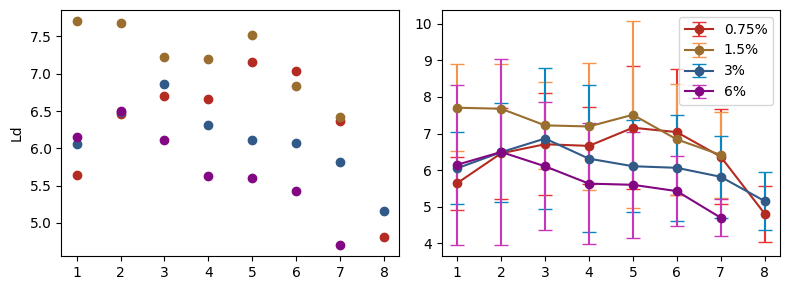

In [20]:
"""
# group by generation
csv "generation" "mean" "std" "counts" of elgRate + # testplot mean
concatenate different elg_df, do statistics and output the results

-----input------
-elg-cv2.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
cell_ID,generation,time_start
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----
elg_rate_stat_gen.csv 
elg_rate_stat_frame.csv 
"generation"
"time", elg rate from each sample labelled with path name, binned by(1) 40min (2) mean division time
"075-mean", "075-std"...

"""

pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}

plotpath = 'ForPub/ForPub-plot/elgRate-250706/'
labels = ['0.75%', '1.5%', '3%', '6%']

colors_dark = ['#B42B22', '#996E2E', '#315A89', '#830783', '#0E8585']  # red, brown, blue, magenta, cyan
colors_light = ['#F5CBBF', '#F4DBB2', '#D5EAED', '#E5CCE5', '#CCE5E5']
colors_mid = ['#EC3232', '#F6944B', '#0787C3', '#C837BB', '#8DC5C5'] # red, brown, blue, magenta, cyan

col_name = "Ld"  # elgRate_b Lb, division_time, Ld


# plot scatter just for test
fig, ax =plt.subplots(1,2, figsize=(8, 3))
for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    
    # concatenate dataFrame for mean and std calculation
    df_concat = pd.DataFrame({})
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
        head, rplcIdx = os.path.split(rplcpath) 
        elgName = rplcIdx + '-elg-cv2_250628.csv' 
        df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
        # [cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
        df_concat = pd.concat([df_concat, df], ignore_index=True) 

#     df_concat["kd"] = np.log(2) /df_concat["division_time"]
    # Group by 'generation' and filter groups with more than 5 samples
    grouped = df_concat.groupby("generation")
        
    # Calculate mean and standard deviation
    gen_stats = grouped[col_name].agg(['mean', 'std', 'count']).reset_index()    
#     gen_stats = grouped["kd"].agg(['mean', 'std', 'count']).reset_index()
    gen_stats_f = gen_stats[gen_stats["count"] > 5]
    ax[0].scatter(gen_stats_f["generation"], gen_stats_f['mean'], color=colors_dark[i], label=labels[i])
    ax[1].errorbar(gen_stats_f["generation"], gen_stats_f["mean"], yerr=gen_stats_f["std"], fmt='o-', color=colors_dark[i], 
                       ecolor=colors_mid[i], capsize=5, label=labels[i])

#     gen_stats.to_csv(os.path.join(plotpath, (c+col_name +'_gen_stats.csv')), index=False)

ax[0].set_ylabel(col_name)
# ax[0].set_ylabel(r"$k_d = \ln 2/t_d$")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
gen_stats_f = gen_stats[gen_stats["count"] > 5]
print(gen_stats_f)


   generation      mean       std  count
0           2  0.018349  0.004775     12
1           3  0.022235  0.006251     24
2           4  0.023883  0.006150     44
3           5  0.023329  0.006190     63
4           6  0.025932  0.006654    103
5           7  0.028711  0.007213    112
6           8  0.035201  0.011365     89


075
34.24242424242424
150
31.130434782608695
300
34.61538461538461
600
37.0625


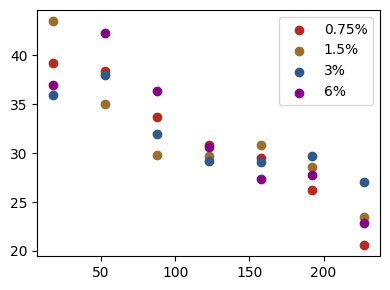

In [15]:
"""
# stastistics grouped by time_start, move to "Stasitics_of_elgRate"
csv for mean and std of elgRate + # testplot mean
"""
plotpath = 'ForPub/ForPub-plot/elgRate-250706/'
col_name = "division_time"  # "elgRate_b" colony growth rate (/min) Lb, division_time
time_bin = 35 # ca. a cell cycle
bins = np.arange(0, 280, time_bin)
time_mid = bins[:-1] + time_bin/2

# plot scatter just for test
fig, ax =plt.subplots(figsize=(4, 3))
for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    
    # concatenate dataFrame for mean and std calculation
    df_concat = pd.DataFrame({})
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
        head, rplcIdx = os.path.split(rplcpath) 
        elgName = rplcIdx + '-elg-cv2.csv' 
        df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
        # [cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
        df_concat = pd.concat([df_concat, df], ignore_index=True) 

    # mean division time before 120min f60
    div_time_mean = df_concat[df_concat["time_start"] < 120]["division_time"].mean()
    print(c)
    print(div_time_mean)
    # bin by time and calculate mean and standard deviation
    df_concat['time_bin'] = pd.cut(df_concat['time_start'], bins=bins, labels=time_mid, right=False)
    
    # Group by 'time_bin' and filter groups with more than 5 samples
    grouped = df_concat.groupby("time_bin", observed=True)
    filtered = grouped.filter(lambda x: len(x) > 5)    
    time_bin_stats =filtered.groupby("time_bin", observed=True)[col_name].agg(['mean', 'std']).reset_index()
 
    ax.scatter(time_bin_stats['time_bin'], time_bin_stats['mean'], color=colors_dark[i], label=labels[i])
    time_bin_stats.to_csv(os.path.join(plotpath, (c+col_name +'_t_stats.csv')), index=False)

plt.legend()
plt.tight_layout()
plt.show()

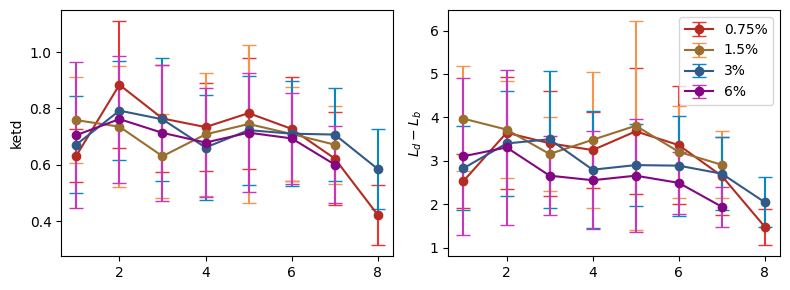

In [21]:
"""
# group by generation, error plot with mean+-std
elgRate * td, Ld-Lb

concatenate different elg_df, do statistics and output the results

-----input------
-elg-cv2.csv in each of the pathDict
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
cell_ID,generation,time_start
"elgRate_b"  elongation rate (/min) calculated from bounding box
-----output----
elg_rate_stat_gen.csv 
elg_rate_stat_frame.csv 
"generation"
"time", elg rate from each sample labelled with path name, binned by(1) 40min (2) mean division time
"075-mean", "075-std"...

"""

pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}

plotpath = 'ForPub/ForPub-plot/elgRate-250706/'
labels = ['0.75%', '1.5%', '3%', '6%']

colors_dark = ['#B42B22', '#996E2E', '#315A89', '#830783', '#0E8585']  # red, brown, blue, magenta, cyan
colors_light = ['#F5CBBF', '#F4DBB2', '#D5EAED', '#E5CCE5', '#CCE5E5']
colors_mid = ['#EC3232', '#F6944B', '#0787C3', '#C837BB', '#8DC5C5'] # red, brown, blue, magenta, cyan


# plot scatter just for test
fig, ax =plt.subplots(1,2, figsize=(8, 3))
for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    
    # concatenate dataFrame for mean and std calculation
    df_concat = pd.DataFrame({})
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
        head, rplcIdx = os.path.split(rplcpath) 
        elgName = rplcIdx + '-elg-cv2_250628.csv' 
        df = pd.read_csv(os.path.join(rplcpath, elgName), header=0)
        # [cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
        df_concat = pd.concat([df_concat, df], ignore_index=True) 

    # Group by 'generation' and filter groups with more than 5 samples
    df_concat["ketd"] = df_concat["elgRate_b"] * df_concat["division_time"]
    df_concat["deltaL"] = df_concat["Ld"] - df_concat["Lb"] 
    
    grouped = df_concat.groupby("generation")
#     filtered = grouped.filter(lambda x: len(x) > 5)
        
    # Calculate mean and standard deviation
    gen_stats0 = grouped["ketd"].agg(['mean', 'std', 'count']).reset_index()  
    gen_stats = gen_stats0[gen_stats0["count"] > 5]
#     ax.scatter(gen_stats["generation"], gen_stats['mean'], color=colors_dark[i], label=labels[i])
    ax[0].errorbar(gen_stats["generation"], gen_stats["mean"], yerr=gen_stats["std"], fmt='o-', color=colors_dark[i], 
                       ecolor=colors_mid[i], capsize=5, label=labels[i])
    
    gen_stats_dl0 = grouped["deltaL"].agg(['mean', 'std', 'count']).reset_index()    
    gen_stats_dl = gen_stats_dl0[gen_stats_dl0["count"] > 5]
    ax[1].errorbar(gen_stats_dl["generation"], gen_stats_dl["mean"], yerr=gen_stats_dl["std"], fmt='o-', color=colors_dark[i], 
                       ecolor=colors_mid[i], capsize=5, label=labels[i])

#     gen_stats.to_csv(os.path.join(plotpath, (c+col_name +'_gen_stats.csv')), index=False)

ax[0].set_ylabel("ketd")
ax[1].set_ylabel(r"$L_d-L_b$")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
"""
grouped by generation
<elgRate> to 1/<td>  <elgRate * td> to <Lb>
<Lb> to 1/<td>   <elgRate> to <Lb>  
"""  

plotpath = 'ForPub/ForPub-plot/elgRate-250706'
fig, ax =plt.subplots(2,2, figsize=(8, 8), sharex='col')

c_list = ['075', '150', '300', '600']
labels = ['0.75%', '1.5%', '3%', '6%']
for i in range(4):
    c = c_list[i]
    ke_stats = pd.read_csv(os.path.join(plotpath, (c+'elgRate_b_gen_stats.csv')), header=0,
                          usecols=["generation", "mean"]).rename(columns={'mean': 'mean_ke'})
    lb_stats = pd.read_csv(os.path.join(plotpath, (c+'Lb_gen_stats.csv')), header=0,
                          usecols=["generation", "mean"]).rename(columns={'mean': 'mean_lb'})
    td_stats = pd.read_csv(os.path.join(plotpath, (c+'division_time_gen_stats.csv')), header=0,
                          usecols=["generation", "mean"]).rename(columns={'mean': 'mean_td'})
    merged = ke_stats.merge(lb_stats, on='generation', how='outer').merge(td_stats, on='generation', how='outer')

    # <elgRate> to 1/<td>
    ax[0,0].plot(1/merged["mean_td"], merged["mean_ke"], 
                 marker='o', linestyle='-', color=colors_light[i], markerfacecolor=colors_dark[i], label=labels[i])
    # <elgRate * td> to <Lb>
    ax[0,1].plot(merged["mean_lb"], merged["mean_td"]*merged["mean_ke"],
                 marker='o', linestyle='-', color=colors_light[i], markerfacecolor=colors_dark[i], label=labels[i])
    # <Lb> to 1/<td>
    ax[1,0].plot(1/merged["mean_td"], merged["mean_lb"], 
                 marker='o', linestyle='-', color=colors_light[i], markerfacecolor=colors_dark[i], label=labels[i])
    # <elgRate> to <Lb>
    ax[1,1].plot(merged["mean_lb"], merged["mean_ke"], 
                 marker='o', linestyle='-', color=colors_light[i], markerfacecolor=colors_dark[i], label=labels[i])

ax[0,0].set_ylabel(r"$\langle k_e  \rangle$")
ax[1,0].set_ylabel(r"$\langle L_b  \rangle$")
ax[1,0].set_xlabel(r"$1/ \langle t_d  \rangle$")
ax[1,0].set_xlim(0.02, 0.05)

ax[0,1].set_ylabel(r"$\langle k_e t_d  \rangle$")
ax[1,1].set_ylabel(r"$\langle k_e  \rangle$")
ax[1,1].set_xlabel(r"$\langle L_b  \rangle$")
ax[1,1].set_xlim(2, 5)
    
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(plotpath, "elgRate.png", dpi=300))